# Comparison between baseline models and cleaned models
### Augmentation. checkpoint average, longer training

Files needed:
* target files:
    * precursors-train.txt: tokenized train set of the precursors
    * product-train.txt: tokenized train set of the product
    * class-multi-train.txt: tokenized file of the reaction class (ex 1.2.1 -> 1 1.2 1.2.1)
* prediction files for both the cleaned and baseline models (models with augmentation/checkpoint average are optional):
    * can_**example_name**_step_xxxxx.out.txt: file with the canonical topn predictions
    * **example_name**_step_xxxxx.out.txt_gold_score: file with the gold scores of the target
    * **example_name**_step_xxxxx.out.txt_log_probs: files with the log probabilites of the topn predictions

Variables to set: **datapath**, **baseline_resultspath** (list), **cleaned_resultspath** (list)

Outputs:
* "figures/": the plots

In [1]:
from onmt_utils.ForwardEvalModel import *
from onmt_utils.plotter_topn import topn , topn_byclass
from onmt_utils.plotter_likelihoods import likelihoods_pdf, likelihoods_pdf_oneclass, \
likelihoods_pdf_allclasses, likelihoods_cdf_allclasses
from onmt_utils.plotter_metrics import CJSD_vs_bins

RDKit WARNING: [09:44:22] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# To analise results with hashing

from rdkit.Chem.rdMolHash import MolHash
from rdkit.Chem.rdMolHash import MolHash, HashFunction
from rdkit import Chem

In [ ]:
# path where to save the plots

%mkdir figures
savepath="figures/"

In [3]:
#Lambda function to costumize the experiment names 

get_names = lambda base_names: ['_'.join(b.split('_')[6:7]) for b in base_names]

In [1]:
datapath = "path/to/target/file"

fe = ForwardEvalModel(datapath,'dataset_name', split = 'test', n_best = 2)

## Add predictions from baseline models

baseline_resultspath = ["path/to/results/files", "path/to/results/files" , "etc.."]
cleaned_resultspath = ["path/to/results/files", "path/to/results/files" , "etc.."]

# augmented version
fe.add_experiment(baseline_resultspath[0], func = get_names, classification=False)
# longer training
fe.add_experiment(baseline_resultspath[1], func = get_names, classification=False)
# average of last 10 checkpoints
fe.add_experiment(baseline_resultspath[2], func = get_names, classification=False)
# average of last 5 checkpoints
fe.add_experiment(baseline_resultspath[3], func = get_names, classification=False)
# non augmented version
fe.add_experiment(baseline_resultspath[4], func = get_names, classification=False)

## Add predictions from cleaned models 

# augmented version
fe.add_experiment(cleaned_resultspath[0], func = get_names, classification=False)
# longer training
fe.add_experiment(cleaned_resultspath[1], func = get_names, classification=False)
# average of last 10 checkpoints
fe.add_experiment(cleaned_resultspath[2], func = get_names, classification=False)
# average of last 5 checkpoints
fe.add_experiment(cleaned_resultspath[3], func = get_names, classification=False)
# non augmented version
fe.add_experiment(cleaned_resultspath[4], func = get_names, classification=False)

fe.print_experiments()

### Top1 accuracies of the models when performing tautomeric hashing

In [3]:
accuracies_tautomers = fe.get_allexp_top_n_accuracy(topn = 1, hashing = HashFunction.HetAtomTautomer)

### Top1 accuracies of the model when performing redox-pairs hashing

In [2]:
accuracies_redox = fe.get_allexp_top_n_accuracy(topn = 1, hashing = HashFunction.RedoxPair)

### Top1 (no hashing)

<Figure size 432x360 with 0 Axes>

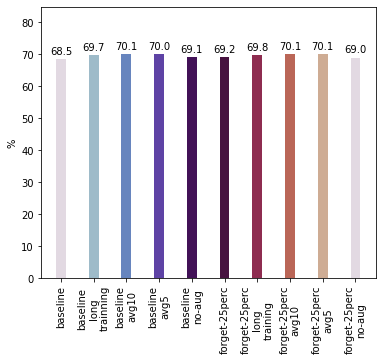

In [6]:
topn(fe, n=1, font =10, save = True, png_path=savepath, ylimit=85)


### Top1 without single-precursor-reactions

In [9]:
def get_top_n_accuracy_eff(evaluation_obj, name, n=1):
    correct = 0
    df = evaluation_obj.split_evaluator.df
    df['single_prec'] = df['source'].map(lambda x : x.find('.'))
    df = df.loc[df['single_prec'] != -1]
    
    df_filter = [True for i in range(len(df))]
    for i in range(1, n+1):
        correct += df[df_filter][f'{name}_top_{i}_correct'].sum()
        df_filter = df_filter & (df[f'{name}_top_{i}_correct']==False)

    return correct / len(df) * 100

def get_exp_top_n_accuracy_eff(evaluation_obj, exp_name, topn = 1):
    acc = 0.0
    if exp_name in evaluation_obj.name_basename_dict:
        acc = get_top_n_accuracy_eff(evaluation_obj, exp_name, n = topn)
    else:
        print('Sorry, this experiment is not present')
    return acc

def get_allexp_top_n_accuracy_eff(evaluation_obj, topn = 1):
    acc = []
    labels = []
    for exp_name in evaluation_obj.name_basename_dict:
        labels.append(exp_name)
        acc.append(get_exp_top_n_accuracy_eff(evaluation_obj,exp_name, topn = topn))

    return acc, labels

In [10]:
accuracies_no_single_prec = get_allexp_top_n_accuracy_eff(fe, topn = 1)

### Comparison of the accuracies

In [12]:
def autolabel(rects, ax, vert_off = (3,0), font = 8):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{0:.1f}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext = vert_off,  # 3 points vertical offset
                    textcoords="offset points",
                    ha='left', va='center').set_fontsize(font)

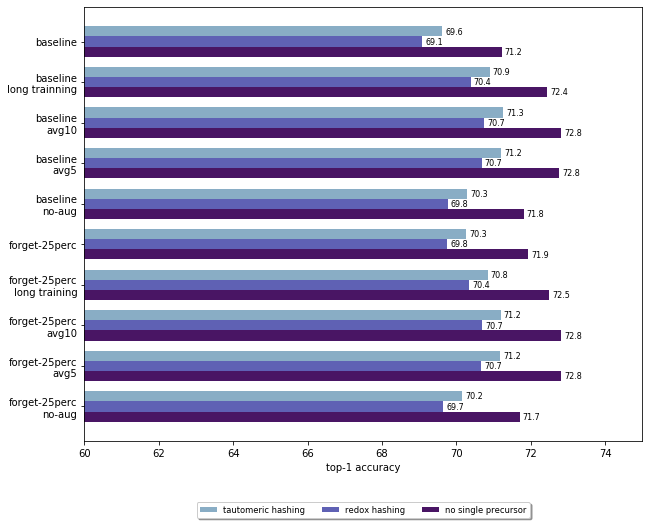

In [50]:
from matplotlib.font_manager import FontProperties
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

labels = ['baseline','baseline\nlong trainning', 'baseline\navg10', 'baseline\navg5','baseline\nno-aug',\
             'forget-25perc','forget-25perc\nlong training','forget-25perc\navg10', 'forget-25perc\navg5',\
          'forget-25perc\nno-aug']

fontP = FontProperties()
fontP.set_size('small')
col = [ cm.twilight(x) for x in np.linspace(0, 1.0, 8) ]

fig, ax = plt.subplots(figsize=(10,8))
height=0.5

y_pos = np.arange(len(labels))
y_pos = y_pos*2
rect = ax.barh(y_pos - height, accuracies_tautomers[0], height, align='center', color=col[1], label="tautomeric hashing")
autolabel(rect, ax)
rect =ax.barh(y_pos, accuracies_redox[0], height, align='center', color=col[2], label="redox hashing")
autolabel(rect, ax)
rect = ax.barh(y_pos + height, accuracies_no_single_prec[0], height, align='center', color=col[3],label="no single precursor")
autolabel(rect, ax)

ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
plt.xlim((60, 75))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('top-1 accuracy')
plt.legend(prop=fontP,loc='upper center', bbox_to_anchor=(0.5, -0.13),
          fancybox=True, shadow=True, ncol=3)

plt.savefig(savepath + f'/hashing_comparison.pdf', bbox_inches='tight')

## Cumulative Jensen Shannon Divergence

### 12 superclasses

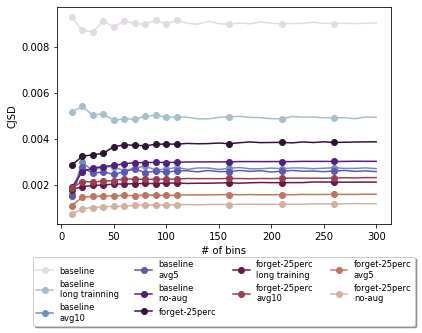

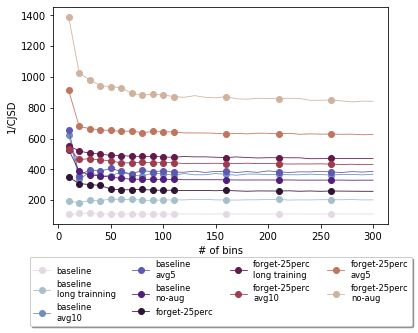

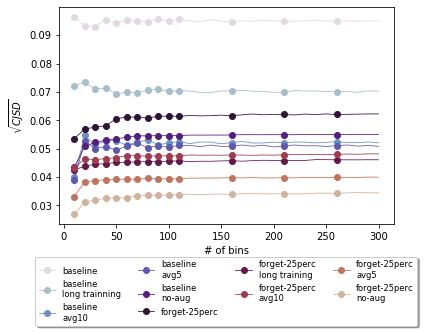

In [22]:
def CJSD_vs_bins(evaluation_obj, n=1, save=False, png_path=savepath, figsize=(6, 5), superclasses=range(12),\
                 x_min = 0.5, bins_range = range(10,310,10))

### 11 superclasses

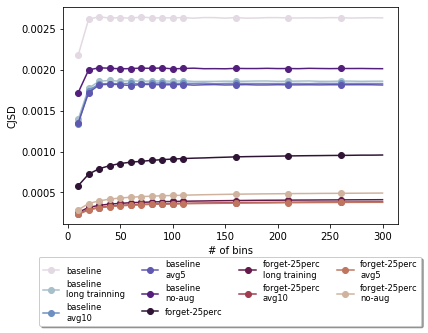

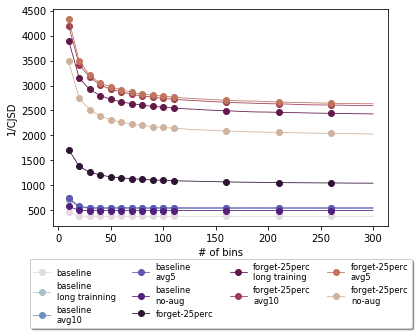

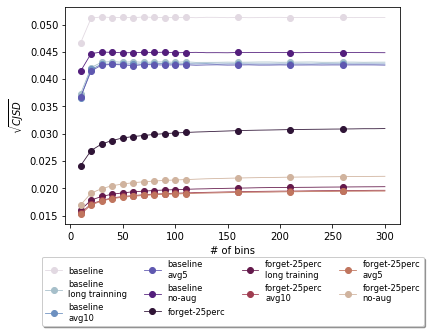

In [25]:
def CJSD_vs_bins(evaluation_obj, n=1, save=False, png_path=savepath, figsize=(6, 5), superclasses=range(11),\
                 x_min = 0.5, bins_range = range(10,310,10))

## Top1 accuracy per-class

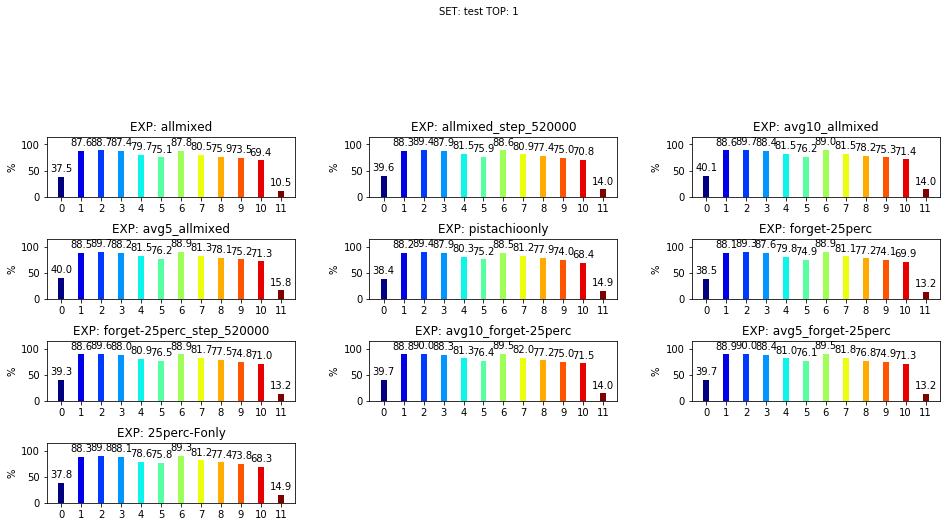

In [15]:
topn_byclass(fe, n=1,save=False, png_path=savepath, figsize=(16, 18),\
             vert_off=(0,3), font=10, ylimit=115.0, n_classes=12, hspace=0.7, wspace=0.3 )


## Cumulative distributions of the likelihoods per-class

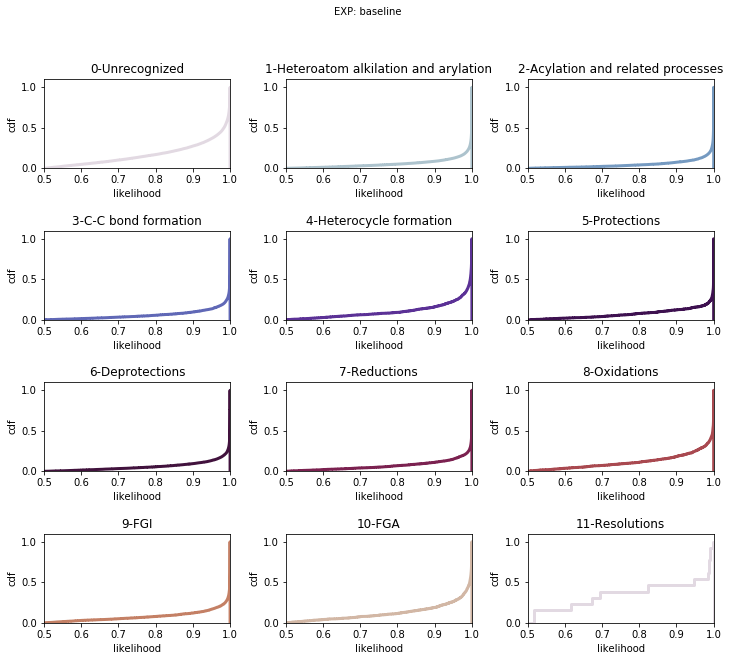

In [27]:
likelihoods_cdf_allclasses(fe, 'forget-25perc', n=1, save=True, \
                             png_path=savepath, \
                             figsize=(12, 10), font=10, x_min = 0.5, \
                             ylimit=1.1, hspace=0.7, wspace=0.3)


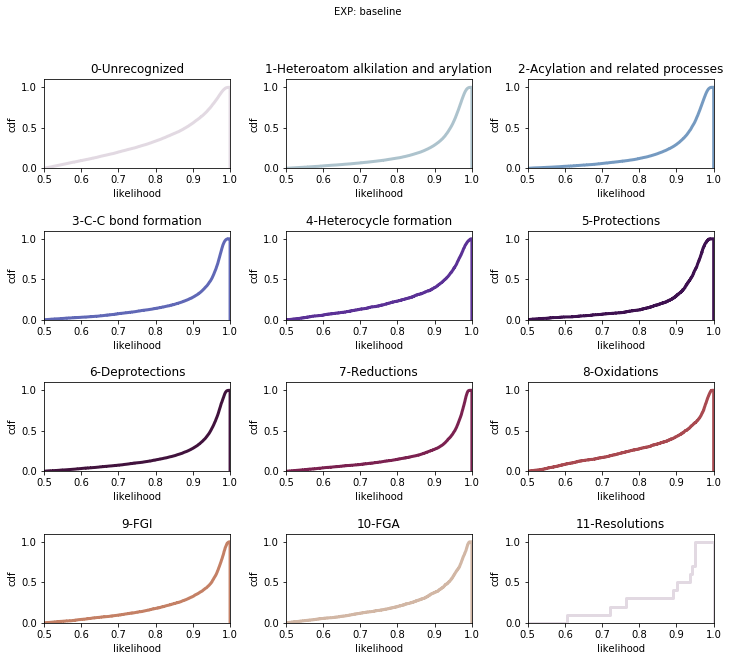

In [28]:
likelihoods_cdf_allclasses(fe, 'pistachioonly', n=1, save=True, \
                             png_path=savepath, \
                             figsize=(12, 10), font=10, x_min = 0.5, \
                             ylimit=1.1, hspace=0.7, wspace=0.3)


## Probability density distributions of the likelihoods per-class

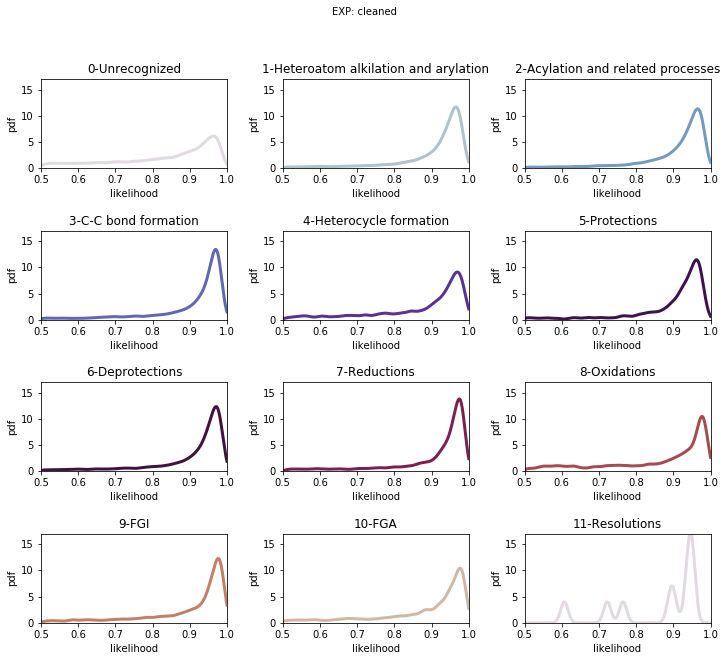

In [30]:
likelihoods_pdf_allclasses(fe, 'pistachioonly', n=1, save=True, \
                             png_path=savepath, bandwidth=0.01,\
                             figsize=(12, 10), font=10, x_min = 0.5, \
                             ylimit=17, hspace=0.7, wspace=0.3)

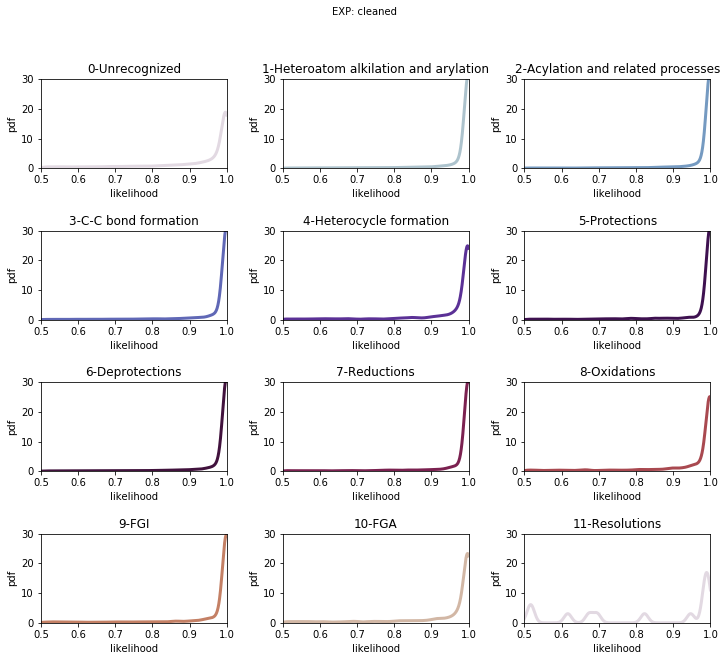

In [31]:
likelihoods_pdf_allclasses(fe, 'forget-25perc', n=1, save=True, \
                             png_path=savepath, bandwidth=0.01,\
                             figsize=(12, 10), font=10, x_min = 0.5, \
                             ylimit=30, hspace=0.7, wspace=0.3)